# INSTALLING LIBRARIES

In [2]:
!pip install --upgrade ipython

In [18]:
!pip install yfinance
!pip install pyspark


In [35]:
!pip install pyspark[sql]
!pip install pyspark[pandas_on_spark]

## ABOUT THE DATASET
This dataset contains historical daily prices for all tickers currently trading on NASDAQ. The up to date list is available from nasdaqtrader.com. The historic data is retrieved from Yahoo finance via yfinance python package.

It contains prices for up to 29 of December 2023.
The date for every symbol is saved in CSV format with common fields:

* Date - specifies trading date
* Open - opening price
* High - maximum price during the day
* Low - minimum price during the day
* Close - close price adjusted for splits
* Adj Close - adjusted close price adjusted for both dividends and splits.
* Ticker - Type of Security Name
* Volume - the number of shares that changed hands during a given day.

# IMPORTING LIBRARIES

In [62]:
import yfinance as yf
import datetime as dt
import pandas as pd #data processing
import numpy as np #linear algebra
import matplotlib.pyplot as plt #visialization
%matplotlib inline
import seaborn as sns
import pyspark
# FOR CLUSTER ANALYSIS
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler,StringIndexer,StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import ClusteringEvaluator,MulticlassClassificationEvaluator


import warnings as wr
wr.filterwarnings('ignore')

# STARTING THE PySpark SERVER

In [63]:
import os

#os.environ["PYSPARK_PYTHON"] = r"C:\Users\LAPTOP0534\miniconda3\envs\pyspark_v3.3.0"
os.environ["PYSPARK_PYTHON"] = r"C:\Users\tooba.alvi\Anaconda3\Lib\site-packages\pyspark"
#os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\LAPTOP0534\miniconda3\envs\pyspark_v3.3.0"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\tooba.alvi\Anaconda3\Lib\site-packages\pyspark"
os.environ["JAVA_HOME"] = r"C:\Program Files (x86)\Java\jre1.8.0_341" 

In [64]:
# Initialize Spark session

from pyspark.sql import SparkSession 

spark = SparkSession.builder.appName('cluster').getOrCreate() 
print('Spark Version: {}'.format(spark.version))
#sc = spark.sparkContext
#importing sparksession
#sc.setLogLevel("INFO")

Spark Version: 3.5.0


# DATASET INITIALIZATION WITH SPARK

In [13]:
#Loading the data 
data = spark.read.csv("stock_data.csv",header=True,inferSchema=True) 
  
#show the data in the above file using the below command 
data.show()


+------------------+------------------+------------------+------------------+------------------+-------+------+----------+
|              Open|              High|               Low|             Close|         Adj Close| Volume|Ticker|      Date|
+------------------+------------------+------------------+------------------+------------------+-------+------+----------+
|               9.0| 9.899999618530273| 8.399999618530273| 8.949999809265137| 8.949999809265137| 185046|  ARVL|2023-01-03|
|              9.75|11.600000381469727|               9.0|11.600000381469727|11.600000381469727| 178766|  ARVL|2023-01-04|
|11.850000381469727|              12.0|10.300000190734863|10.699999809265137|10.699999809265137| 145310|  ARVL|2023-01-05|
|10.399999618530273|10.800000190734863|              9.75|              10.0|              10.0| 104930|  ARVL|2023-01-06|
|10.649999618530273|              11.0|             10.25|10.600000381469727|10.600000381469727|  80312|  ARVL|2023-01-09|
|              1

In [14]:
#Print schema 
data.printSchema()

root
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- Date: date (nullable = true)



In [15]:
print(type(data.Open))

<class 'pyspark.sql.column.Column'>


In [20]:
data.summary().show()

+-------+-------------------+-------------------+-------------------+------------------+------------------+--------------------+------+
|summary|               Open|               High|                Low|             Close|         Adj Close|              Volume|Ticker|
+-------+-------------------+-------------------+-------------------+------------------+------------------+--------------------+------+
|  count|               8645|               8645|               8645|              8645|              8645|                8645|  8645|
|   mean|  81.80269150041978|  85.32145538782801|  77.77814181576218| 80.76114745040707| 80.71584420275781|1.2205365913938694E7|  NULL|
| stddev|  559.5472954697018|  594.0801728718307|  524.7833113717536| 552.9918959086212| 552.9898648390152| 2.873651159613667E7|  NULL|
|    min|0.07400000095367432|0.07999999821186066|0.06599999964237213|0.0729999989271164|0.0729999989271164|                   0|  ARVL|
|    25%|  2.069999933242798| 2.1500000953674316

# SUMMARY ANALYSIS ON FILTERED SAMPLES

In [19]:

# Generate summary statistics for Adjusted close price greater than 10

filtered_df1 = data.select("Low","High","Volume").filter("Close > 10.0")
filtered_df1.summary().show()



+-------+------------------+------------------+--------------------+
|summary|               Low|              High|              Volume|
+-------+------------------+------------------+--------------------+
|  count|              3958|              3958|                3958|
|   mean|  166.273875415536|182.44958641506193|1.8636624970944922E7|
| stddev| 766.2538113415321|  868.077488434941| 3.785117130040473E7|
|    min| 6.949999809265137|10.020000457763672|                   0|
|    25%|14.319999694824219|  15.1899995803833|              189700|
|    50%| 23.40999984741211|24.639999389648438|             1041300|
|    75%|              46.0|  52.9900016784668|            15531400|
|    max|            9225.0|           10800.0|           306590600|
+-------+------------------+------------------+--------------------+



In [18]:

# Generate summary statistics for Opening Stocks greater than 15

filtered_df2 = data.select("Low", "High","Volume").filter("Open > 15")
filtered_df2.summary().show()

+-------+------------------+------------------+--------------------+
|summary|               Low|              High|              Volume|
+-------+------------------+------------------+--------------------+
|  count|              2945|              2945|                2945|
|   mean| 219.5826441015169|241.17161392866046|1.7577457228183363E7|
| stddev| 882.0812932418922| 999.6857829644205| 4.033670457352698E7|
|    min|11.609999656677246|  15.0600004196167|                3958|
|    25%|  20.5049991607666| 21.93000030517578|              254100|
|    50%|32.369998931884766|33.529998779296875|             1062800|
|    75%| 155.2100067138672|160.60000610351562|            10794700|
|    max|            9225.0|           10800.0|           306590600|
+-------+------------------+------------------+--------------------+



# IMPLEMENT LABEL ENCODING 

In [21]:
from pyspark.ml.feature import StringIndexer

print("The original dataframe is:")
data.show()
ticker_label = StringIndexer(inputCol="Ticker", outputCol="Ticker_label") 
#indexer = StringIndexer(inputCol="City", outputCol="City_label") 
indexed = ticker_label.fit(data).transform(data)
indexed_df=indexed.drop("Ticker","Date").withColumnRenamed("Ticker_label","Ticker")
print("The output dataframe is:")
indexed_df.show()
#spark.sparkContext.stop()

The original dataframe is:
+------------------+------------------+------------------+------------------+------------------+-------+------+----------+
|              Open|              High|               Low|             Close|         Adj Close| Volume|Ticker|      Date|
+------------------+------------------+------------------+------------------+------------------+-------+------+----------+
|               9.0| 9.899999618530273| 8.399999618530273| 8.949999809265137| 8.949999809265137| 185046|  ARVL|2023-01-03|
|              9.75|11.600000381469727|               9.0|11.600000381469727|11.600000381469727| 178766|  ARVL|2023-01-04|
|11.850000381469727|              12.0|10.300000190734863|10.699999809265137|10.699999809265137| 145310|  ARVL|2023-01-05|
|10.399999618530273|10.800000190734863|              9.75|              10.0|              10.0| 104930|  ARVL|2023-01-06|
|10.649999618530273|              11.0|             10.25|10.600000381469727|10.600000381469727|  80312|  ARVL|2

# K-MEANS CLUSTER ANALYSIS 

In [27]:
cluster_df=indexed_df.drop("Ticker",'Volume')

In [28]:
cluster_df.columns

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [31]:
cluster_df.fillna(0, subset=cluster_df.columns)

DataFrame[Open: double, High: double, Low: double, Close: double, Adj Close: double]

In [32]:
vecAssembler = VectorAssembler(outputCol="features")
vecAssembler.setInputCols(["Open", "High", "Low", "Close", "Adj Close"])

VectorAssembler_e1cd5f06beb4

In [33]:
final_data = vecAssembler.transform(cluster_df) 
final_data.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[9.0,9.8999996185...|
|[9.75,11.60000038...|
|[11.8500003814697...|
|[10.3999996185302...|
|[10.6499996185302...|
+--------------------+
only showing top 5 rows



In [34]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False) 

# Compute summary statistics by fitting the StandardScaler 
scalerModel = scaler.fit(final_data) 

# Normalize each feature to have unit standard deviation. 
final_data = scalerModel.transform(final_data) 

final_data.select('scaledFeatures').show(5)


+--------------------+
|      scaledFeatures|
+--------------------+
|[0.01608443124087...|
|[0.01742480051094...|
|[0.02117783514889...|
|[0.01858645319659...|
|[0.01903324295328...|
+--------------------+
only showing top 5 rows



# CLUSTER EVALUATION USING Silhouette Coefficient
* Score of 1: The data point is compact within its cluster and far away from other clusters.
* Score of 0: The data point is on or close to the decision boundary between two clusters.
* Score near 0: The clusters overlap.
* Score above 0.5: The clustering is good.
* Score between 0.25 and 0.5: The clustering is fair.
* Score below 0.25: The clustering is bad.
* Negative value: The sample is likely assigned to the wrong cluster

In [35]:
#Defining the metric 
silhouette_score=[] 

evaluator = ClusteringEvaluator(predictionCol='prediction',featuresCol='scaledFeatures', metricName='silhouette', 
distanceMeasure='squaredEuclidean') 

for i in range(2,10): 
    kmeans=KMeans(featuresCol='scaledFeatures', k=i) 
    model=kmeans.fit(final_data) 
    predictions=model.transform(final_data) 
    score=evaluator.evaluate(predictions) 
    silhouette_score.append(score) 
    print('Silhouette Score for k =',i,'is',score)


Silhouette Score for k = 2 is 0.997074249452472
Silhouette Score for k = 3 is 0.995225191598388
Silhouette Score for k = 4 is 0.9943580635457298
Silhouette Score for k = 5 is 0.988829771744016
Silhouette Score for k = 6 is 0.9888100564088439
Silhouette Score for k = 7 is 0.9599497829279637
Silhouette Score for k = 8 is 0.9513692180397549
Silhouette Score for k = 9 is 0.9651446841427012


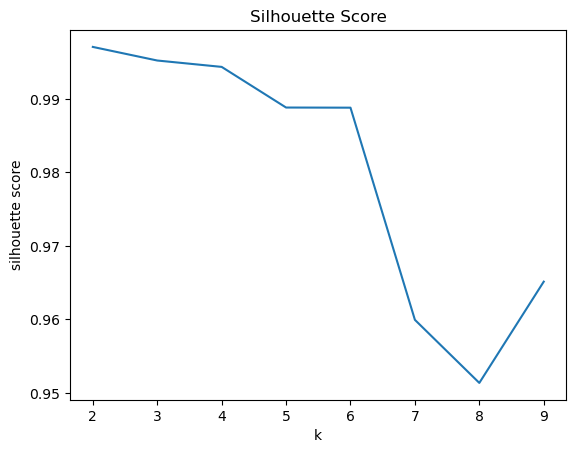

In [36]:
#Visualizing the silhouette scores in a plot 
import matplotlib.pyplot as plt 

plt.plot(range(2,10),silhouette_score) 
plt.xlabel('k') 
plt.ylabel('silhouette score') 
plt.title('Silhouette Score') 
plt.show()


In [40]:
# Trains a k-means model. 
kmeans = KMeans(featuresCol='scaledFeatures',k=5) 
model = kmeans.fit(final_data) 
predictions = model.transform(final_data)

In [47]:
# Printing cluster centers 
centers = model.clusterCenters() 

for center in centers: 
    print("Cluster Centers:", center) 
    


Cluster Centers: [0.05452212 0.05233389 0.05695134 0.05503415 0.05495141]
Cluster Centers: [14.26844707 14.39199689 14.314664   14.39821602 14.3982689 ]
Cluster Centers: [4.78511829 4.68371127 4.70194068 4.65196691 4.65198399]
Cluster Centers: [9.34907566 9.11335329 9.35207426 9.15474537 9.154779  ]
Cluster Centers: [2.1664065  2.14600084 2.08696975 2.07703985 2.07704748]


In [48]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 5 rows



# BUILDING MACHINE LEARNING PIPELINE USING PySpark

In [ ]:
ml_df=indexed_df.drop('Volume')
ml_df

In [49]:
dt = DecisionTreeClassifier(labelCol="Ticker",featuresCol= "features")

In [50]:
pipeline = Pipeline(stages=[ticker_label,vecAssembler,dt])

In [52]:
(trainingData,testData)=ml_df.randomSplit([0.7,0.3])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

In [53]:
predictions.select('prediction','Ticker','features').show(20)

+----------+------+--------------------+
|prediction|Ticker|            features|
+----------+------+--------------------+
|      11.0|  30.0|[0.08200000226497...|
|      11.0|  30.0|[0.08399999886751...|
|      11.0|  30.0|[0.08900000154972...|
|      11.0|  30.0|[0.09300000220537...|
|      11.0|  30.0|[0.11900000274181...|
|      11.0|  30.0|[0.12600000202655...|
|      11.0|  30.0|[0.14000000059604...|
|      11.0|  30.0|[0.15299999713897...|
|      11.0|  33.0|[0.21199999749660...|
|      11.0|  33.0|[0.21400000154972...|
|      11.0|  33.0|[0.21999999880790...|
|      11.0|  33.0|[0.22100000083446...|
|      11.0|  33.0|[0.22200000286102...|
|      11.0|  33.0|[0.23000000417232...|
|      11.0|  33.0|[0.23000000417232...|
|      11.0|  30.0|[0.23299999535083...|
|      11.0|  33.0|[0.23600000143051...|
|      11.0|  33.0|[0.23899999260902...|
|      11.0|  33.0|[0.23999999463558...|
|      11.0|   8.0|[0.24099999666213...|
+----------+------+--------------------+
only showing top

In [59]:
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",labelCol="Ticker",metricName="accuracy")
accuracy= evaluator.evaluate(predictions)
print("Accuracy:"+str(accuracy))
print("Test Error= %g" % (1.0-accuracy))

Accuracy:0.319921875
Test Error= 0.680078


In [61]:
# Create the Spark Session using Kafka
from pyspark.sql import SparkSession

spark2 = SparkSession \
    .builder \
    .appName("Streaming from Kafka") \
    .config("spark.streaming.stopGracefullyOnShutdown", True) \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0') \
    .config("spark.sql.shuffle.partitions", 4) \
    .master("local[*]") \
    .getOrCreate()

spark2